#Sudoku Studying

##Dataset

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
!gdown --id 1uDxRM845nsuhX2nFU2V-XsQM33voDXHM

In [ ]:
!gdown --id 1kNf1LtUMbZ7cld9RTxi07A_J3tPL9lbr

In [8]:
# !cp /content/drive/MyDrive/Sudoku_dataset/*.zip ./

In [ ]:
!unzip archive.zip

In [10]:
import pandas as pd

test = pd.read_csv("sudoku.csv", sep=',')
test.head(5)

,puzzle,solution
0,0700000430400096108006349000940520003584600200...,6795182435437296188216349577943521863584617292...
1,3010865040465210705000000014008000020803479000...,3719865248465213795924738614638197522853479167...
2,0483015603600080909106700030200009355090102006...,7483915623652487919126754834217869355894132766...
3,0083170000042051090000400703271609049014500000...,2983176457642851391539462783271689549814537266...
4,0408906300001368208007405190004670524500207002...,1428956379751368248367425193984671524513287962...


###Dataset for NN

In [11]:
import torch.utils.data as data
import torch
import pandas as pd


def create_sudoku_tensors(df, train_split=0.8):
    s = df.shape[0]

    def one_hot_encode(s):
        zeros = torch.zeros((1, 81, 9), dtype=torch.float)
        for a in range(81):
            zeros[0, a, int(s[a]) - 1] = 1 if int(s[a]) > 0 else 0
        return zeros

    quizzes_t = df.puzzle.apply(one_hot_encode)
    solutions_t = df.solution.apply(one_hot_encode)
    quizzes_t = torch.cat(quizzes_t.values.tolist())
    solutions_t = torch.cat(solutions_t.values.tolist())
    randperm = torch.randperm(s)
    train = randperm[:int(train_split * s)]
    test = randperm[int(train_split * s):]

    return data.TensorDataset(quizzes_t[train], solutions_t[train]),\
        data.TensorDataset(quizzes_t[test], solutions_t[test]), test


def create_constraint_mask():
    constraint_mask = torch.zeros((81, 3, 81), dtype=torch.float)
    # row constraints
    for a in range(81):
        r = 9 * (a // 9)
        for b in range(9):
            constraint_mask[a, 0, r + b] = 1

    # column constraints
    for a in range(81):
        c = a % 9
        for b in range(9):
            constraint_mask[a, 1, c + 9 * b] = 1

    # box constraints
    for a in range(81):
        r = a // 9
        c = a % 9
        br = 3 * 9 * (r // 3)
        bc = 3 * (c // 3)
        for b in range(9):
            r = b % 3
            c = 9 * (b // 3)
            constraint_mask[a, 2, br + bc + r + c] = 1

    return constraint_mask


def load_dataset(subsample=4000):
    dataset = pd.read_csv("sudoku.csv", sep=',')
    my_sample = dataset.sample(subsample)
    train_set, test_set, test_ind = create_sudoku_tensors(my_sample)
    return train_set, test_set, dataset.loc[test_ind]

In [12]:
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim
import numpy as np

batch_size = 500



train_set, test_set, bactracking_test_set = load_dataset(subsample=100000)




dataloader_ = data.DataLoader(train_set,
                              batch_size=batch_size,
                              shuffle=True)

dataloader_test_ = data.DataLoader(test_set,
                                  batch_size=batch_size,
                                  shuffle=True)

loss = nn.MSELoss()



In [13]:
print("Train set size = ", len(train_set))
print("Test set size = ", len(test_set))

Train set size =  80000
Test set size =  20000


##Backtracking

In [14]:
def find_empty(bo):
    for i in range(81):
      # print(bo[i])
      if(bo[i] == "0"):
        #print("Find empty!")
        return(i)
    return None

In [15]:
def valid(bo, num, pos):
    # Check row
    r = 9 * (pos // 9)
    for b in range(9):
      if bo[r + b] == num and (r + b != pos):
        return False

    # Check column
    c = pos % 9
    for b in range(9):
      if bo[c + 9 * b] == num and (c + 9 * b != pos):
        return False

    # Check box
    r = pos // 9
    c = pos % 9
    br = 3 * 9 * (r // 3)
    bc = 3 * (c // 3)
    for b in range(9):
        r = b % 3
        c = 9 * (b // 3)
        if bo[br + bc + r + c] == num and (br + bc + r + c != pos):
          return False

    return True

In [18]:
def backtracking_solve(bo, bos):
    find = find_empty(bo)
    if find is None:
        bos.append(bo)
        return True
    else:
        position = find

    for i in range(1,10):
        if valid(bo, str(i), position):
            bo = bo[:position] + str(i) + bo[position+1:]

            if backtracking_solve(bo, bos):
                return True

            bo = bo[:position] + "0" + bo[position+1:]

    return False

In [19]:
def is_backtracking_solve_correctly(x, y):
  bos = []
  backtracking_solve(x, bos)
  return bos[0] == y

In [20]:
%%time
number_of_right_backtracking_solutions = bactracking_test_set[["puzzle", "solution"]].apply(lambda x: is_backtracking_solve_correctly(x[0], x[1]), axis = 1).sum()

CPU times: user 5min 8s, sys: 1.05 s, total: 5min 9s
Wall time: 5min 10s


In [21]:
accuracy_of_backtracking = (number_of_right_backtracking_solutions / len(bactracking_test_set)) * 100

print(f"Accuracy of Backtracking: {accuracy_of_backtracking}%")

Accuracy of Backtracking: 100.0%


##Naked Twin approach

In [22]:
nakedtwin_test_set = bactracking_test_set

In [23]:
import numpy as np
import pandas as pd

import collections

rows = 'ABCDEFGHI'
cols = '123456789'

def cross(A, B):
    "Cross product of elements in A and elements in B."
    return [s + t for s in A for t in B]


boxes = cross(rows, cols)

row_units = [cross(r, cols) for r in rows]

column_units = [cross(rows, c) for c in cols]

square_units = [cross(rs, cs) for rs in ('ABC', 'DEF', 'GHI') for cs in ('123', '456', '789')]

unitlist = row_units + column_units + square_units 

units = dict((s, [u for u in unitlist if s in u]) for s in boxes)

peers = dict((s, set(sum(units[s], [])) - set([s])) for s in boxes)


def assign_value(values, box, value):
    """
    Please use this function to update your values dictionary!
    Assigns a value to a given box. If it updates the board record it.
    """
    values[box] = value
    return values


def naked_twins(values):
    """Eliminate values using the naked twins strategy.
    Args:
        values(dict): a dictionary of the form {'box_name': '123456789', ...}
    Returns:
        the values dictionary with the naked twins eliminated from peers.
    """

    # Find all instances of naked twins
    for unit in unitlist:
        # Occurrences dict
        unit_values_counter = collections.Counter([values[box] for box in unit])
        for twins, count in unit_values_counter.items():
            # twins will occur twice in a unit, triples will occur three times, and quads four times
            if 1 < count == len(twins):
                for box in unit:
                    # for all boxes except twins boxes in a unit,
                    # remove all potential values that exist in twins, triples, quads..
                    if values[box] != twins and set(values[box]).intersection(set(twins)):
                        for digit in twins:
                            values = assign_value(values, box, values[box].replace(digit, ''))
    return values


def grid_values(grid):
    """
    Convert grid into a dict of {square: char} with '123456789' for empties.
    Args:
        grid(string) - A grid in string form.
    Returns:
        A grid in dictionary form
            Keys: The boxes, e.g., 'A1'
            Values: The value in each box, e.g., '8'. If the box has no value, then the value will be '123456789'.
    """
    chars = []
    digits = '123456789'
    for c in grid:
        if c in digits:
            chars.append(c)
        if c == '0':
            chars.append(digits)
    assert len(chars) == 81
    return dict(zip(boxes, chars))

def eliminate(values):
    """
        Go through all the boxes, and whenever there is a box with a value, eliminate this value from the values of all its peers.
        Input: A sudoku in dictionary form.
        Output: The resulting sudoku in dictionary form.
        """
    solved_values = [box for box in values.keys() if len(values[box]) == 1]
    for box in solved_values:
        digit = values[box]
        for peer in peers[box]:
            values[peer] = values[peer].replace(digit, '')
    return values


def only_choice(values):
    """
        Go through all the units, and whenever there is a unit with a value that only fits in one box, assign the value to this box.
        Input: A sudoku in dictionary form.
        Output: The resulting sudoku in dictionary form.
        """
    for unit in unitlist:
        for digit in '123456789':
            dplaces = [box for box in unit if digit in values[box]]
            if len(dplaces) == 1:
                values[dplaces[0]] = digit
    return values


def reduce_puzzle(values):
    """
    Iterate eliminate() and only_choice(). If at some point, there is a box with no available values, return False.
    If the sudoku is solved, return the sudoku.
    If after an iteration of both functions, the sudoku remains the same, return the sudoku.
    Input: A sudoku in dictionary form.
    Output: The resulting sudoku in dictionary form.
    """
    stalled = False
    while not stalled:
        solved_values_before = len([box for box in values.keys() if len(values[box]) == 1])
        values = eliminate(values)
        values = only_choice(values)
        values = naked_twins(values)
        solved_values_after = len([box for box in values.keys() if len(values[box]) == 1])
        stalled = solved_values_before == solved_values_after
        if len([box for box in values.keys() if len(values[box]) == 0]):
            return False
    return values


def search(values):
    "Using depth-first search and propagation, create a search tree and solve the sudoku."
    # First, reduce the puzzle using the previous function
    values = reduce_puzzle(values)
    if values is False:
        return False  ## Failed earlier
    if all(len(values[s]) == 1 for s in boxes):
        return values  ## Solved!
    # Choose one of the unfilled squares with the fewest possibilities
    min_possibility_box = min([box for box in boxes if len(values[box]) > 1])
    # Now use recursion to solve each one of the resulting sudokus, and if one returns a value (not False), return that answer!
    for digit in values[min_possibility_box]:
        new_sudoku = values.copy()
        new_sudoku[min_possibility_box] = digit
        attempt = search(new_sudoku)
        if attempt:
            return attempt


def nakedtwin_solve(grid):
    values = grid_values(grid)
    values = search(values)
    return values

In [24]:
def is_nakedtwin_solve_correctly(x, y):
  prediction = nakedtwin_solve(x)
  answer = grid_values(y)
  return prediction == answer

In [25]:
%%time
number_of_right_nakedtwin_solutions = nakedtwin_test_set[["puzzle", "solution"]].apply(lambda x: is_nakedtwin_solve_correctly(x[0], x[1]), axis = 1).sum()

CPU times: user 1min 5s, sys: 220 ms, total: 1min 5s
Wall time: 1min 5s


In [26]:
accuracy_of_nakedtwin = (number_of_right_nakedtwin_solutions / len(nakedtwin_test_set)) * 100

print(f"Accuracy of Naked Twin approach: {accuracy_of_nakedtwin}%")

Accuracy of Naked Twin approach: 100.0%


##NN solving

###Model

In [27]:
import torch
import torch.nn as nn


class SudokuSolver(nn.Module):
    def __init__(self, constraint_mask, n=9, hidden1=100):
        super(SudokuSolver, self).__init__()
        self.constraint_mask = constraint_mask.view(1, n * n, 3, n * n, 1)
        self.n = n
        self.hidden1 = hidden1

        # Feature vector is the 3 constraints
        self.input_size = 3 * n

        self.l1 = nn.Linear(self.input_size,
                            self.hidden1, bias=False)
        self.a1 = nn.ReLU()
        self.l2 = nn.Linear(self.hidden1,
                            n, bias=False)
        self.softmax = nn.Softmax(dim=1)

    # x is a (batch, n^2, n) tensor
    def forward(self, x):
        n = self.n
        bts = x.shape[0]
        c = self.constraint_mask
        min_empty = (x.sum(dim=2) == 0).sum(dim=1).max()
        x_pred = x.clone()
        for a in range(min_empty):
            # score empty numbers
            # print(x.get_device(), c.get_device())
            constraints = (x.view(bts, 1, 1, n * n, n) * c).sum(dim=3)
            # empty cells
            empty_mask = (x.sum(dim=2) == 0)

            f = constraints.reshape(bts, n * n, 3 * n)
            y_ = self.l2(self.a1(self.l1(f[empty_mask])))

            s_ = self.softmax(y_)

            # Score the rows
            x_pred[empty_mask] = s_

            s = torch.zeros_like(x_pred)
            s[empty_mask] = s_
            # find most probable guess
            score, score_pos = s.max(dim=2)
            mmax = score.max(dim=1)[1]
            # fill it in
            nz = empty_mask.sum(dim=1).nonzero().view(-1)
            mmax_ = mmax[nz]
            device = 'cuda:0' if torch.cuda.is_available() else "cpu"
            ones = torch.ones(nz.shape[0]).to(device)
            x.index_put_((nz, mmax_, score_pos[nz, mmax_]), ones)
        return x_pred, x

###Train

In [28]:
device = 'cuda:0' if torch.cuda.is_available() else "cpu"
constraint_mask = create_constraint_mask().to(device)
sudoku_solver = SudokuSolver(constraint_mask)
sudoku_solver.to(device)

optimizer = optim.Adam(sudoku_solver.parameters(),
                       lr=0.01,
                       weight_decay=0.000)

In [29]:
device

'cuda:0'

Test error =  0.027468518518518514
Train error =  0.028093518518518525


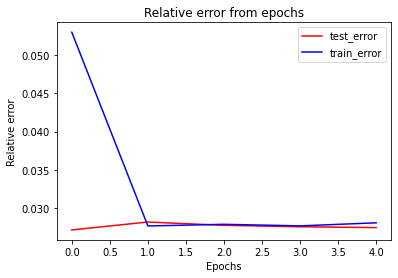

In [30]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

epochs = 5
loss_train = []
loss_test = []
for e in range(epochs):
    batch_loss_train = []

    batch_loss_test = []
    for i_batch, ts_ in enumerate(dataloader_):
        sudoku_solver.train()
        optimizer.zero_grad()
        ts_[0] = ts_[0].to(device)
        ts_[1] = ts_[1].to(device)
        pred, mat = sudoku_solver(ts_[0])
        ls = loss(pred, ts_[1])
        errors = mat.max(dim=2)[1]\
                != ts_[1].max(dim=2)[1]
        # print(errors.sum().cpu().item())
        batch_loss_train.append(errors.sum().cpu().item() / (batch_size * 81))
        ls.backward()
        optimizer.step()
        #break

        # print("Epoch " + str(e) + " batch " + str(i_batch)
        #       + ": " + str(ls.item()))
        sudoku_solver.eval()
        with torch.no_grad():
            n = 500
            rows = torch.randperm(test_set.tensors[0].shape[0])[:n]
            test_pred, test_fill = sudoku_solver(test_set.tensors[0].to(device)[rows])
            # print(test_fill.shape)
            errors = test_fill.max(dim=2)[1]\
                != test_set.tensors[1].to(device)[rows].max(dim=2)[1]
            batch_loss_test.append(errors.sum().cpu().item() / (n * 81))
            # print("Cells in error: " + str(errors.sum().item()))
            # print("Loss test = ", batch_loss_test)
            # print("Loss train = ", batch_loss_train)
        #plt.clf()
        # fig = plt.subplots()
        if(e == 0):
            plt.plot(batch_loss_test, 'r', label = 'test_error')
            plt.plot(batch_loss_train, 'b', label = 'train_error')
            plt.title("Relative error from batch")
            plt.xlabel("Batch")
            plt.ylabel("Relative error")
            plt.legend()
            plt.savefig("graph_b.pdf")
            plt.show()
            time.sleep(0.2)
            clear_output(wait = True)
    sudoku_solver.eval()
    batch_loss_test = []
    for i_batch, tv_ in enumerate(dataloader_test_):
      with torch.no_grad():
        tv_[0] = tv_[0].to(device)
        tv_[1] = tv_[1].to(device)
        pred, mat = sudoku_solver(tv_[0])
      ls = loss(pred, tv_[1])
      errors = mat.max(dim=2)[1]\
              != tv_[1].max(dim=2)[1]
      batch_loss_test.append(errors.sum().cpu().item() / (batch_size * 81))

    loss_test.append(np.mean(batch_loss_test))
    loss_train.append(np.mean(batch_loss_train))
    print("Test error = ", loss_test[-1])
    print("Train error = ", loss_train[-1])
    plt.plot(loss_test, 'r', label = 'test_error')
    plt.plot(loss_train, 'b', label = 'train_error')
    plt.title("Relative error from epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Relative error")
    plt.legend()
    plt.savefig("graph.pdf")
    plt.show()
    time.sleep(0.2)
    clear_output(wait = True) 

In [31]:
# torch.save(sudoku_solver.state_dict(), "/content/drive/MyDrive/Sudoku_dataset/best_model.pth") 

In [32]:
# device = 'cuda:0' if torch.cuda.is_available() else "cpu"
# constraint_mask = create_constraint_mask().to(device)
# sudoku_solver = SudokuSolver(constraint_mask)
# sudoku_solver.to(device)
# sudoku_solver.load_state_dict(torch.load("best_model.pth", map_location=torch.device('cpu')))
# sudoku_solver.eval()

In [33]:
%%time

correctly_solved_sudokus = 0
error_filled_cells = 0
for i_batch, tv_ in enumerate(dataloader_test_):
      with torch.no_grad():
        tv_[0] = tv_[0].to(device)
        tv_[1] = tv_[1].to(device)
        pred, mat = sudoku_solver(tv_[0])
      errors = mat.max(dim=2)[1]\
              != tv_[1].max(dim=2)[1]
      error_filled_cells += errors.cpu().sum().item()
      correctly_solved_sudokus += (errors.sum(dim = 1).cpu() == 0).sum().item()

CPU times: user 27.4 s, sys: 34.9 ms, total: 27.4 s
Wall time: 27.3 s


In [34]:
accuracy_cells = round((1 - error_filled_cells / (len(test_set) * 9**2)) * 100, 1)
accuracy_full = round(100 * correctly_solved_sudokus / (len(test_set)), 1)

print(f"Accuracy of neural network (percentage of correctly filled cells): {accuracy_cells}%")
print(f"Accuracy of neural network (percentage of fully correctly filled sudokas): {accuracy_full}%")

Accuracy of neural network (percentage of correctly filled cells): 97.3%
Accuracy of neural network (percentage of fully correctly filled sudokas): 87.4%


##NN + Naked Twin

In [35]:
def to_cor_type(arr):
  new_list = [x+1 for x in list(arr)]
  answer = ''.join(map(str, new_list))
  return(answer)

def is_correct(s):
  for i in range(len(s)):
    if(valid(s, s[i], i) is False):
      return False
  return True

In [36]:
%%time

mistake = 0
for i_batch, tv_ in enumerate(dataloader_test_):
      with torch.no_grad():
        tv_[0] = tv_[0].to(device)
        tv_[1] = tv_[1].to(device)
        init = tv_[0].clone()
        pred, mat = sudoku_solver(tv_[0])
      sums = init.sum(dim = 2).cpu().numpy()
      ind = init.max(dim=2)[1].cpu().numpy()
      mat_ = mat.max(dim=2)[1].cpu().numpy()
      tv1 = tv_[1].max(dim=2)[1].cpu().numpy()
      for i in range(len(mat.max(dim=2)[1])):
        answer = 0
        
        if(is_correct(to_cor_type(mat_[i]))):
          answer = grid_values(to_cor_type(mat_[i]))
        else:
          sums_i = sums[i]
          ind_i = sums[i] * (ind[i] + 1)
          answer = nakedtwin_solve("".join(list(map(str, ind_i.astype(int)))))
        if(answer != grid_values(to_cor_type(tv1[i]))):
          mistake += 1

CPU times: user 52.1 s, sys: 162 ms, total: 52.3 s
Wall time: 52.2 s


In [37]:
accuracy_cells = round((1 - mistake / (len(test_set) * 9**2)) * 100, 1)

print(f"Accuracy of neural network + Naked Twin approach: {accuracy_cells}%")

Accuracy of neural network + Naked Twin approach: 100.0%
